In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from env import get_db_url

## Acquire

In [2]:
query = """
SELECT  bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet AS sqft, taxvaluedollarcnt AS tax_value, fips,taxamount 
FROM properties_2017
JOIN predictions_2017 USING (id)
JOIN propertylandusetype USING (propertylandusetypeid)
WHERE (transactiondate  >='2017-05-01' AND transactiondate <= '2017-06-30') AND propertylandusetypeid = '261'
AND taxvaluedollarcnt <= 1000000;
"""
df = pd.read_sql(query, get_db_url("zillow"))
df.head(3)

,bathroomcnt,bedroomcnt,sqft,tax_value,fips,taxamount
0,2.0,4.0,1604.0,498347.0,6037.0,6089.82
1,3.0,3.0,2384.0,549917.0,6037.0,6679.55
2,2.0,3.0,1574.0,235272.0,6037.0,3876.31


In [3]:
df.dtypes

bathroomcnt    float64
bedroomcnt     float64
sqft           float64
tax_value      float64
fips           float64
taxamount      float64
dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14860 entries, 0 to 14859
Data columns (total 6 columns):
bathroomcnt    14860 non-null float64
bedroomcnt     14860 non-null float64
sqft           14828 non-null float64
tax_value      14860 non-null float64
fips           14860 non-null float64
taxamount      14828 non-null float64
dtypes: float64(6)
memory usage: 696.7 KB


## Prep

In [5]:
df = df.dropna()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14802 entries, 0 to 14859
Data columns (total 6 columns):
bathroomcnt    14802 non-null float64
bedroomcnt     14802 non-null float64
sqft           14802 non-null float64
tax_value      14802 non-null float64
fips           14802 non-null float64
taxamount      14802 non-null float64
dtypes: float64(6)
memory usage: 809.5 KB


In [7]:
df.fips.value_counts()

6037.0    11512
6059.0     2533
6111.0      757
Name: fips, dtype: int64

In [8]:
df.head(3)

,bathroomcnt,bedroomcnt,sqft,tax_value,fips,taxamount
0,2.0,4.0,1604.0,498347.0,6037.0,6089.82
1,3.0,3.0,2384.0,549917.0,6037.0,6679.55
2,2.0,3.0,1574.0,235272.0,6037.0,3876.31


In [10]:
df['tax_rate'] = df.taxamount / df.tax_value
df.head()

,bathroomcnt,bedroomcnt,sqft,tax_value,fips,taxamount,tax_rate
0,2.0,4.0,1604.0,498347.0,6037.0,6089.82,0.012220
1,3.0,3.0,2384.0,549917.0,6037.0,6679.55,0.012146
2,2.0,3.0,1574.0,235272.0,6037.0,3876.31,0.016476
3,2.0,2.0,1619.0,340000.0,6037.0,4206.15,0.012371
4,2.0,4.0,1721.0,629951.0,6037.0,6861.51,0.010892


## States and counties of the single unit properties located at
- By using Federal Information Processing Standards(fips) provided in the data, I found a link through google:
- https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013697, in where it can be found that: 
- fips 6037 is correponding to Los Angeles county, CA
- fips 6059 is correponding to Orange county, CA
- fips 6111 is correponding to Ventura county, CA
- All of the three counties are located in the state of California.

In [11]:
LA = df[df['fips'] == 6037]
Orange = df[df['fips'] == 6059]
Ventura = df[df['fips'] == 6111]

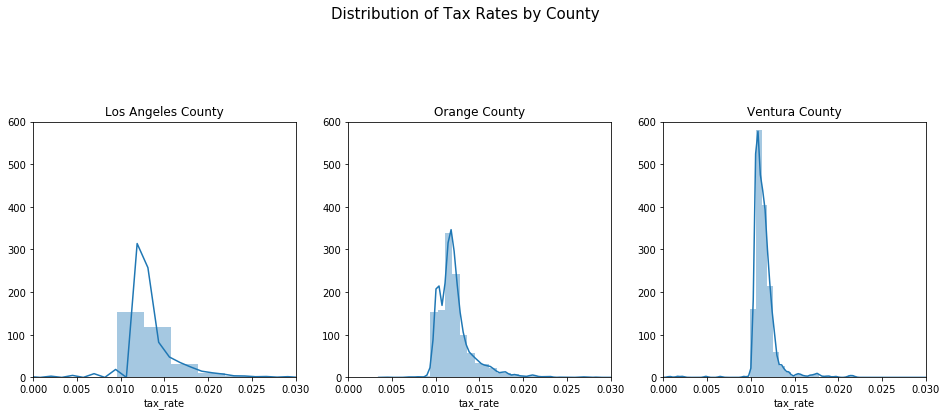

In [12]:
plt.figure(figsize=(16, 16))
plt.suptitle('Distribution of Tax Rates by County', fontsize=15)

plt.subplot(331)
sns.distplot(LA.tax_rate)
plt.xlim(0, .03)
plt.ylim(0, 600)
plt.title('Los Angeles County')

plt.subplot(332)
sns.distplot(Orange.tax_rate,)
plt.xlim(0, .03)
plt.ylim(0, 600)
plt.title('Orange County')

plt.subplot(333)
sns.distplot(Ventura.tax_rate,)
plt.xlim(0, .03)
plt.ylim(0, 600)
plt.title('Ventura County')
plt.show()

In [13]:
import split_scale

In [14]:
df = df[['bathroomcnt','bedroomcnt','sqft', 'tax_value']]

In [15]:
train, test = split_scale.split_my_data(df)

In [16]:
train.head()

,bathroomcnt,bedroomcnt,sqft,tax_value
5986,3.0,4.0,1960.0,229658.0
12828,1.0,3.0,961.0,202311.0
11807,1.0,2.0,690.0,692643.0
11208,3.0,4.0,2162.0,224000.0
10030,2.0,4.0,1470.0,678186.0


In [17]:
train.describe()

,bathroomcnt,bedroomcnt,sqft,tax_value
count,11841.000000,11841.000000,11841.000000,11841.000000
mean,2.073854,3.181404,1688.616586,339286.722659
std,0.821387,0.903837,684.381184,220503.057234
min,0.000000,0.000000,60.000000,5302.000000
25%,2.000000,3.000000,1211.000000,169935.000000
50%,2.000000,3.000000,1544.000000,296064.000000
75%,2.500000,4.000000,2017.000000,463419.000000
max,7.000000,9.000000,9200.000000,1000000.000000


In [18]:
scaler, train, test = split_scale.standard_scaler(train, test)

In [19]:
train.head(3)

,bathroomcnt,bedroomcnt,sqft,tax_value
5986,1.127588,0.905729,0.396555,-0.497197
12828,-1.307422,-0.200712,-1.063219,-0.621223
11807,-1.307422,-1.307153,-1.459214,1.602568


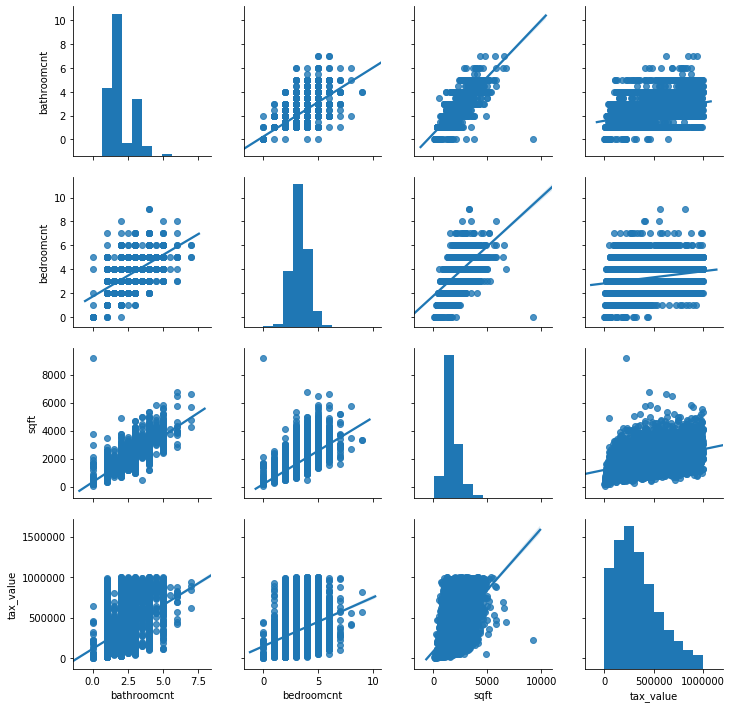

In [20]:
sns.pairplot(df, kind="reg")
plt.show()

# Exploration

(0, 4)

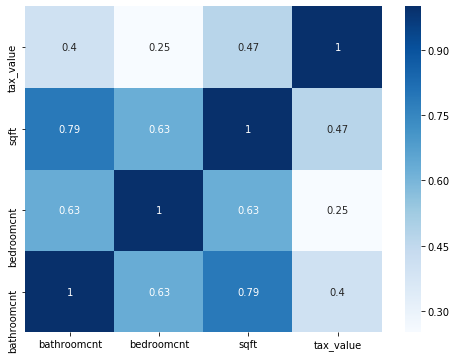

In [21]:
plt.figure(figsize=(8,6))
sns.heatmap(train.corr(), cmap='Blues', annot=True)
plt.ylim(0, 4)

### Correlation Test

$H_0$: There is no linear relationship between sqft and tax_value.

$H_a$: There is a linear relationship between sqft and tax_value.

In [22]:
from math import sqrt
from scipy import stats

In [23]:
alpha = 0.01
r, p = stats.pearsonr(train.sqft, train.tax_value)
r, p

(0.47302490043214185, 0.0)

In [24]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Reject the null hypothesis


$H_0$: There is no linear relationship between bathroomcnt and tax_value.

$H_a$: There is a linear relationship between bathroomcnt and tax_value.

In [25]:
alpha = 0.01
r, p = stats.pearsonr(train.bathroomcnt, train.tax_value)
r, p

(0.4031011989652694, 0.0)

$H_0$: There is no linear relationship between bedroomcnt and tax_value.

$H_a$: There is a linear relationship between bedroomcnt and tax_value.

In [26]:
alpha = 0.01
r, p = stats.pearsonr(train.bedroomcnt, train.tax_value)
r, p

(0.25070392818053844, 3.826869470604966e-169)

$H_0$: There is no linear relationship between bathroomcnt and sqft.

$H_a$: There is a linear relationship between bathroomcnt and sqft.

In [27]:
alpha = 0.01
r, p = stats.pearsonr(train.bathroomcnt, train.sqft)
r, p

(0.7907649969357715, 0.0)

$H_0$: There is no linear relationship between bathroomcnt and bedroomcnt.

$H_a$: There is a linear relationship between bathroomcnt and bedroomcnt.

In [28]:
alpha = 0.01
r, p = stats.pearsonr(train.bathroomcnt, train.bedroomcnt)
r, p

(0.6339995152150681, 0.0)

$H_0$: There is no linear relationship between bedroomcnt and sqft.

$H_a$: There is a linear relationship between bedroomcnt and sqft.

In [29]:
alpha = 0.01
r, p = stats.pearsonr(train.bedroomcnt, train.sqft)
r, p

(0.6261586116589335, 0.0)

## Insights drawn from correlation tests

- Among independent variables (bathroomcnt,bedroomcnt,sqft) and dependent variable (tax_value), there is a weak-postive linear relatioship between sqft and tax_value; there is also a weak-positive linear relatioship between bathroomcnt and tax_value; there is a very weak-positive linear relatioship between bedroomcnt and tax_value,

- Among independent variables themsleves, there is a strong-postive linear relationship between bathroomcnt and sqft; there is a moderate-postive linear relatioship between bathroomcnt and bedroomcnt; there is also a moderate-postive linear relationship between bedroomcnt and sqft.

# Modeling

In [30]:
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.feature_selection import RFE
import sklearn.linear_model
import warnings
warnings.filterwarnings("ignore")
import split_scale

In [31]:
predictions = pd.DataFrame({
    'actual_tax_value': train.tax_value
})
predictions.head()

,actual_tax_value
5986,-0.497197
12828,-0.621223
11807,1.602568
11208,-0.522857
10030,1.537002


In [32]:
predictions['baseline'] = predictions.actual_tax_value.mean()
predictions.head(3)

,actual_tax_value,baseline
5986,-0.497197,9.765668e-17
12828,-0.621223,9.765668e-17
11807,1.602568,9.765668e-17


In [33]:
# model 1
X = train[['bathroomcnt']]
y = train.tax_value
lm1 = sklearn.linear_model.LinearRegression()
lm1.fit(X, y)
predictions['bath_lm1'] = lm1.predict(X)

In [34]:
# model 2
X = train[['bedroomcnt']]
y = train.tax_value
lm2 = sklearn.linear_model.LinearRegression()
lm2.fit(X, y)
predictions['bed_lm2'] = lm2.predict(X)

In [35]:
# model 3
X = train[['sqft']]
y = train.tax_value
lm3 = sklearn.linear_model.LinearRegression()
lm3.fit(X, y)
predictions['sqft_lm3'] = lm3.predict(X)

In [36]:
# model 4
X = train[['bedroomcnt','sqft']]
y = train.tax_value
lm4 = sklearn.linear_model.LinearRegression()
lm4.fit(X, y)
predictions['bed&sqft_lm4'] = lm4.predict(X)

In [37]:
# model 5
X = train[['bathroomcnt','sqft']]
y = train.tax_value
lm5 = sklearn.linear_model.LinearRegression()
lm5.fit(X, y)
predictions['bath&sqft_lm5'] = lm5.predict(X)

In [38]:
# model 6
X = train[['bathroomcnt','bedroomcnt']]
y = train.tax_value
lm6 = sklearn.linear_model.LinearRegression()
lm6.fit(X, y)
predictions['bath&bed_lm6'] = lm6.predict(X)

In [39]:
# model 7
X = train[['bathroomcnt','bedroomcnt','sqft']]
y = train.tax_value
lm7 = sklearn.linear_model.LinearRegression()
lm7.fit(X, y)
predictions['bath&bed&sqft_lm7'] = lm7.predict(X)

In [40]:
predictions.head(3)

,actual_tax_value,baseline,bath_lm1,bed_lm2,sqft_lm3,bed&sqft_lm4,bath&sqft_lm5,bath&bed_lm6,bath&bed&sqft_lm7
5986,-0.497197,9.765668e-17,0.454532,0.227070,0.187580,0.138392,0.250690,0.452980,0.214728
12828,-0.621223,9.765668e-17,-0.527023,-0.050319,-0.502929,-0.537723,-0.539110,-0.532130,-0.603598
11807,1.602568,9.765668e-17,-0.527023,-0.327709,-0.690245,-0.660807,-0.702148,-0.523135,-0.668127


In [41]:
predictions.apply(lambda col: sklearn.metrics.mean_squared_error(predictions.actual_tax_value, col))

actual_tax_value     0.000000
baseline             1.000000
bath_lm1             0.837509
bed_lm2              0.937148
sqft_lm3             0.776247
bed&sqft_lm4         0.772844
bath&sqft_lm5        0.773995
bath&bed_lm6         0.837470
bath&bed&sqft_lm7    0.768309
dtype: float64

## Insights drawn from modeling 

- For three independent variables(bathroomcnt,bedroomcnt,sqft), there are seven possible combinations in total: bathroomcnt, bedroomcnt, sqft, bathroomcnt&bedroomcnt, bathroomcnt&sqft, bedroomcnt&sqft, bathroomcnt&bedroomcnt&sqft.

- I built seven models using those seven combinations, then I used a lambda function to calculate the mean_squared_errors for those models, the least mse I got is from model 7, which is the combination of all three independent variables(bathroomcnt&bedroomcnt&sqft).

- I regarded this model as the best model, and apply the model into the test data.

## Test data applied to the best model

In [42]:
# evaluate the best model on the test data set
X = train[['bathroomcnt','bedroomcnt','sqft']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
y_test = test.tax_value
y_test_predicted = lm.predict(test[['bathroomcnt','bedroomcnt','sqft']])

test_data_mse = sklearn.metrics.mean_squared_error(y_test, y_test_predicted)
test_data_mse

0.7276768446173686


- I applied the test data into the best model, and got test data's mse 0.7277, which is not too far from train data's mse 0.7683. Therefore, the model with three independent variables(bathroomcnt,bedroomcnt,sqft) combined together is a viable model.

# Conclusion

### After evaluating all possible combinations of independent variables. I decided to choose the model that incorporates all three independent variables as the best model . In addition, without any doubt, the best model performs better than the baseline model.